In [1]:
! git clone https://github.com/AndreyK2001/TranslatedReadMe

Cloning into 'TranslatedReadMe'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 0), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 154.27 KiB | 17.14 MiB/s, done.


In [2]:
import torch
from tqdm.notebook import tqdm

#from transformers import BertTokenizer
from transformers import XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler


#from transformers import BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np
import os

In [3]:
def load_data(language = 'en'):
    data = pd.read_excel(f'/content/TranslatedReadMe/{language}_data_from_en.xlsx')
    return data

In [4]:
os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/dS1nPF0JXFToNA" -O ReadMe_en_.zip""")
os.system("unzip /content/ReadMe_en_.zip -d /content")

0

In [5]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    "/content/ReadMe_en_roberta",
    num_labels=6,
    output_attentions=False,
    output_hidden_states=True,
)

tokenizer = XLMRobertaTokenizer.from_pretrained(
    'xlm-roberta-base', do_lower_case=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [6]:
class Pipeline:
    def __init__(self, model, tokenizer, model_language="en"):
        self.model = model
        self.tokenizer = tokenizer

        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"

        self.model = self.model.to(self.device)

    def get_neurons_activations(self, dataloader):
        self.model.eval()

        # Подготовка списка для хранения усредненных скрытых состояний по слоям
        avg_hidens_per_layer = [
            [] for _ in range(13)
        ]  # предполагается, что у модели 12 слоев + входной слой

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            # Создание маски для исключения [PAD] токенов (где input_ids равно 0)
            mask = (
                inputs["input_ids"] != 0
            )  # Создается маска размером как input_ids, True где не PAD
            mask = mask.unsqueeze(-1).expand_as(
                outputs["hidden_states"][0]
            )  # Расширение маски до размера скрытых состояний

            for layer_idx, layer_hidden_states in enumerate(outputs["hidden_states"]):
                # Применение маски к скрытым состояниям
                masked_hidden_states = layer_hidden_states * mask.float()
                # Вычисление суммы и количества не-pad токенов для усреднения
                sum_hidden_states = masked_hidden_states.sum(
                    dim=1
                )  # Сумма по оси токенов
                non_pad_tokens = mask.sum(dim=1)  # Количество не-pad токенов
                # Усреднение скрытых состояний, исключая pad-токены
                avg_hidden_states = sum_hidden_states / non_pad_tokens.clamp(
                    min=1
                )  # Избегание деления на 0
                avg_hidens_per_layer[layer_idx].append(avg_hidden_states)

        # Собираем усредненные скрытые состояния по всему датасету для каждого слоя
        avg_hidens_stacked_per_layer = [
            torch.cat(layer_avg_hidens, dim=0)
            for layer_avg_hidens in avg_hidens_per_layer
        ]

        # Стекинг усредненных скрытых состояний для всех слоев
        all_avg_hidens_tensor = torch.stack(avg_hidens_stacked_per_layer)

        return all_avg_hidens_tensor  # [layers, batch, neurons]

    def predict_dataloader(self, dataloader):
        self.model.eval()

        predictions = []

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)

            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

        predictions = np.concatenate(predictions, axis=0)

        return predictions

    def predict_proba(self, data):
        encoded_data_predict = self.tokenizer.batch_encode_plus(
            data,
            add_special_tokens=True,
            return_attention_mask=True,
            padding="max_length",
            max_length=512,
            truncation=True,
            return_tensors="pt",
        )

        input_ids_predict = encoded_data_predict["input_ids"]
        attention_masks_predict = encoded_data_predict["attention_mask"]
        dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict)

        batch_size = 10
        dataloader_predict = DataLoader(
            dataset_predict,
            sampler=SequentialSampler(dataset_predict),
            batch_size=batch_size,
        )

        predictions = self.predict_dataloader(dataloader_predict)

        return predictions

    def predict(self, data):
        predictions = self.predict_proba(data)
        return np.argmax(predictions, axis=1).flatten()


In [7]:
predictor = Pipeline(model, tokenizer, 'en')

In [8]:
def label_to_category(labels, categories):
    filtered_labels = [1 if itm in categories else 0 for itm in labels]
    return filtered_labels

def get_label_dict(categories):
    label_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
    for i in categories:
        label_dict[i] = 1
    return label_dict

In [17]:
category = [5, 6]

raw_data = load_data('en')
labels = label_to_category(raw_data.iloc[:, 1].values, category)
label_dict = get_label_dict(category)

In [18]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def plot_confusion_matrix(preds, labels, label_dict, category, language="en", model_lang=None):

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels, preds)
    label_names = [0, 1]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm[::-1],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names[::-1],
        annot_kws={"size": 14},
    )
    f1_macro = round(f1_score(preds, labels, average="macro"), 2)
    if model_lang is None:
        plt.title(f"Выборка: {language}, f1 macro: {f1_macro}", size=20)
    else:
        plt.title(f"Модель: {model_lang}, Выборка: {language}, f1 macro: {f1_macro}", size=20)
    plt.ylabel("Истинные классы", size=16)
    plt.xlabel("Предсказанные классы", size=16)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.show()

def bootstrap_f1_macro(preds, labels, n_iterations=10, n_samples=100):
    f1_scores = []
    for i in range(n_iterations):
        preds_resampled, labels_resampled = resample(preds, labels, replace=False, n_samples=n_samples)
        f1 = f1_score(labels_resampled, preds_resampled, average='macro')
        f1_scores.append(f1)
    return f1_scores

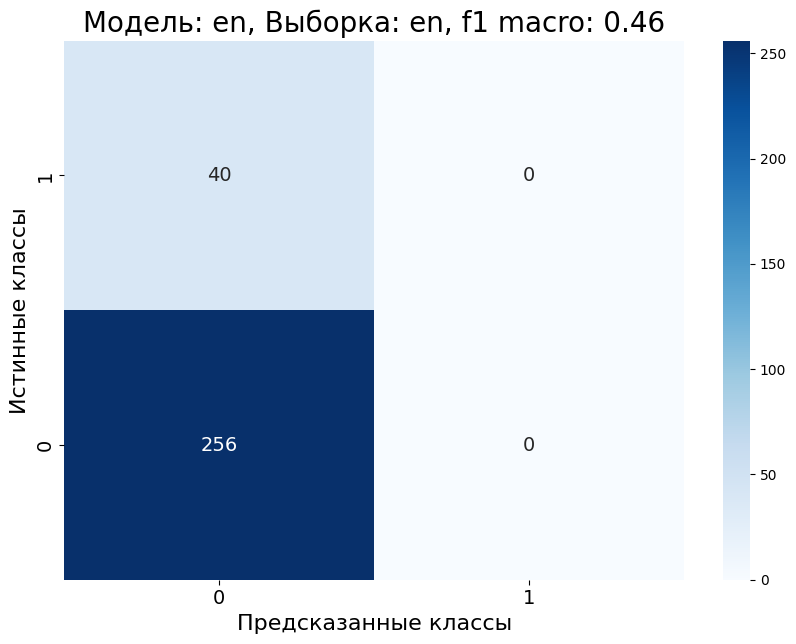

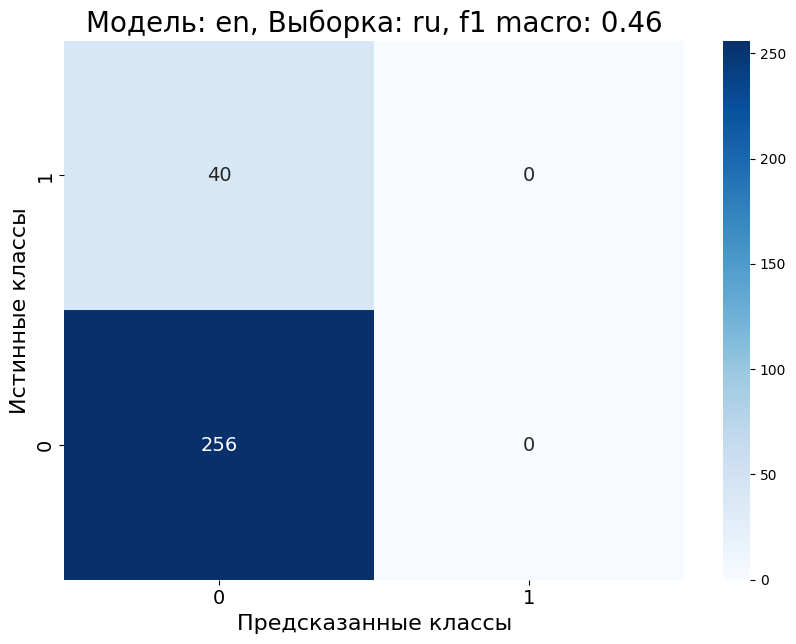

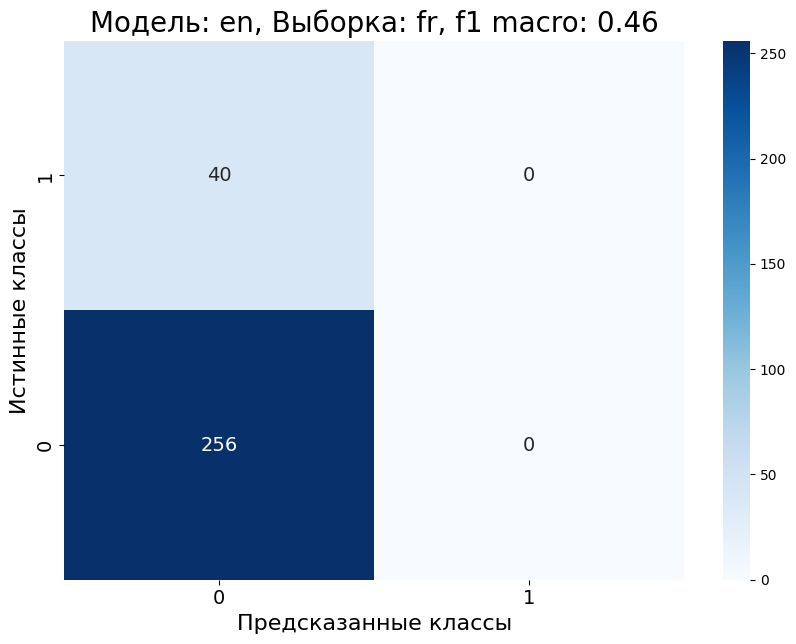

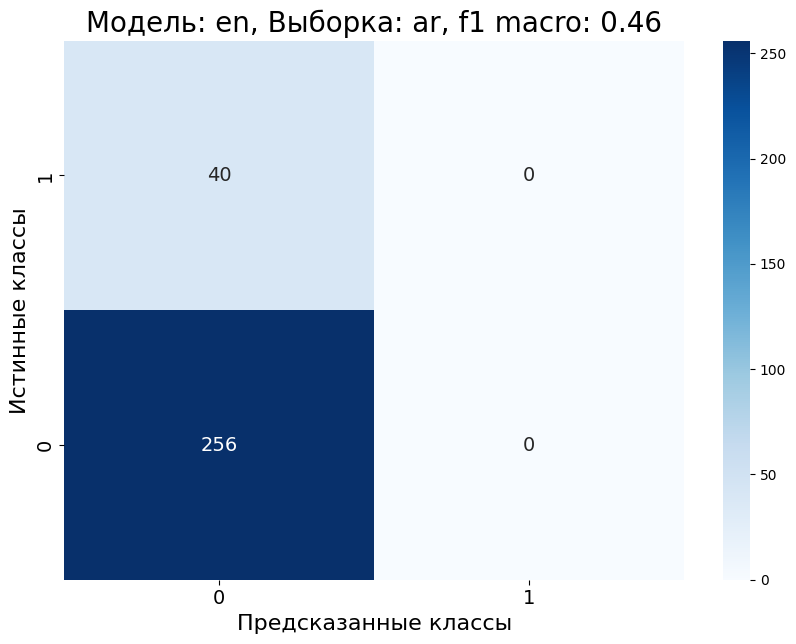

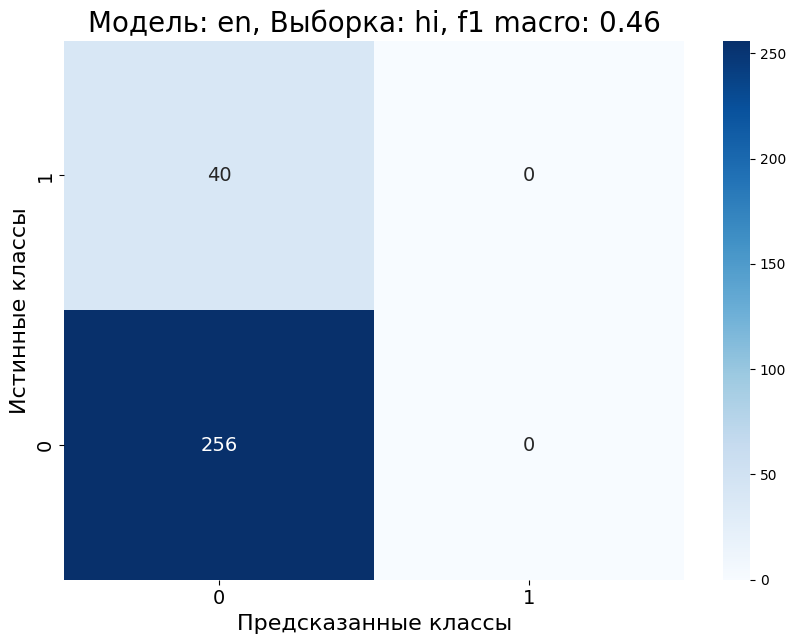

In [19]:
for lang in ['en', 'ru', 'fr', 'ar', 'hi']:
    preds = predictor.predict(load_data(lang).iloc[:, 0].values)
    preds = label_to_category(preds, category)
    plot_confusion_matrix(preds, labels, label_dict, category, language=lang, model_lang='en')

In [20]:
f1_scores_all = []

for lang in ['en', 'ru', 'fr', 'ar', 'hi']:
    preds = predictor.predict(load_data(lang).iloc[:, 0].values)
    preds = label_to_category(preds, category)
    f1_scores = bootstrap_f1_macro(preds, labels, n_iterations=100)
    f1_scores_all.append({
            'Value': f1_scores,
            'Language': lang
        })

df_f1_scores = pd.DataFrame(f1_scores_all)
df_f1_scores.to_csv('readme_roberta_5_6.csv', index=False)

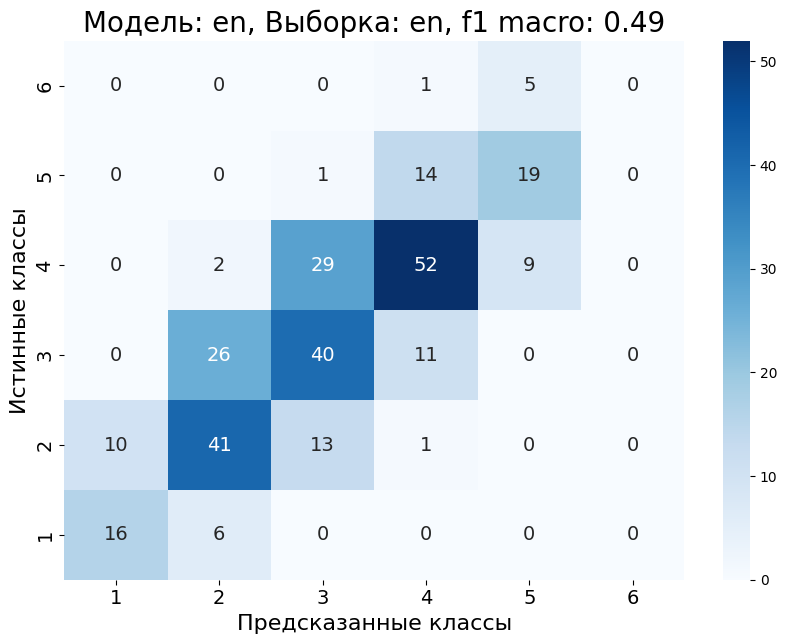

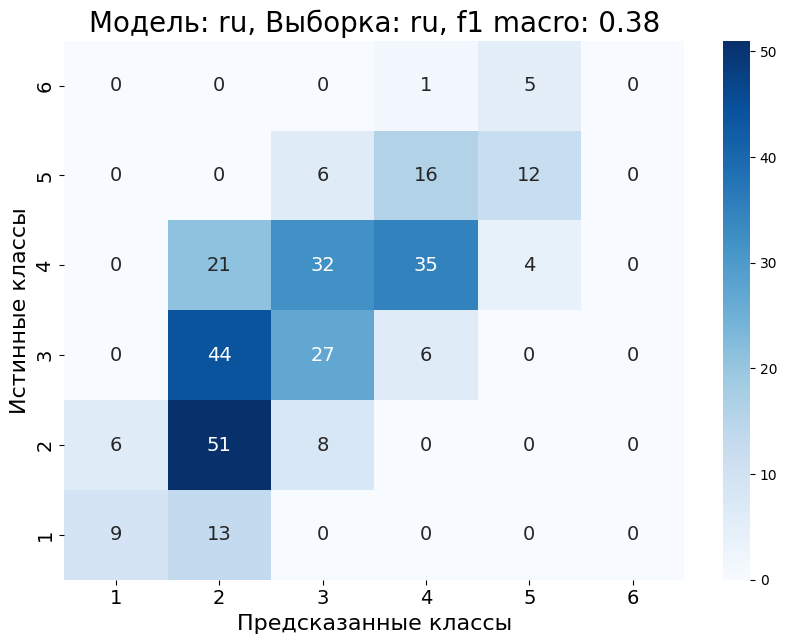

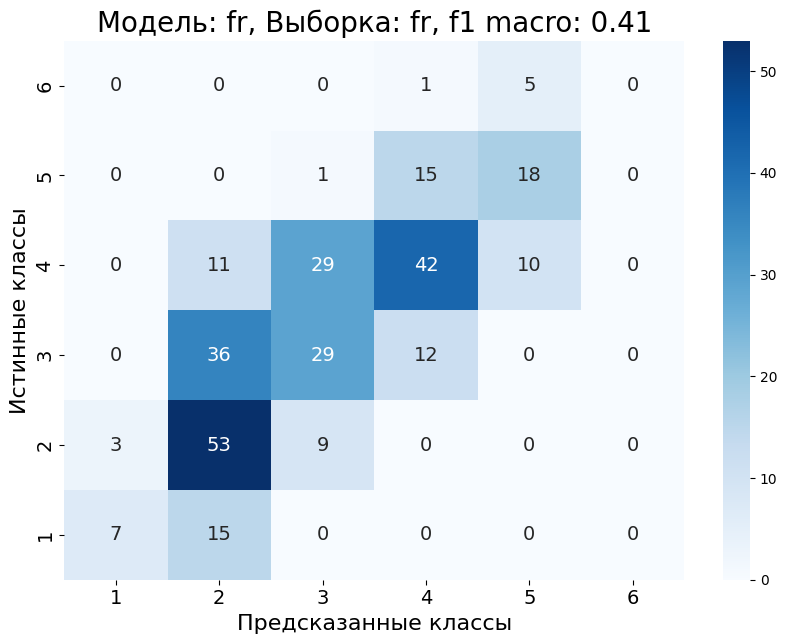

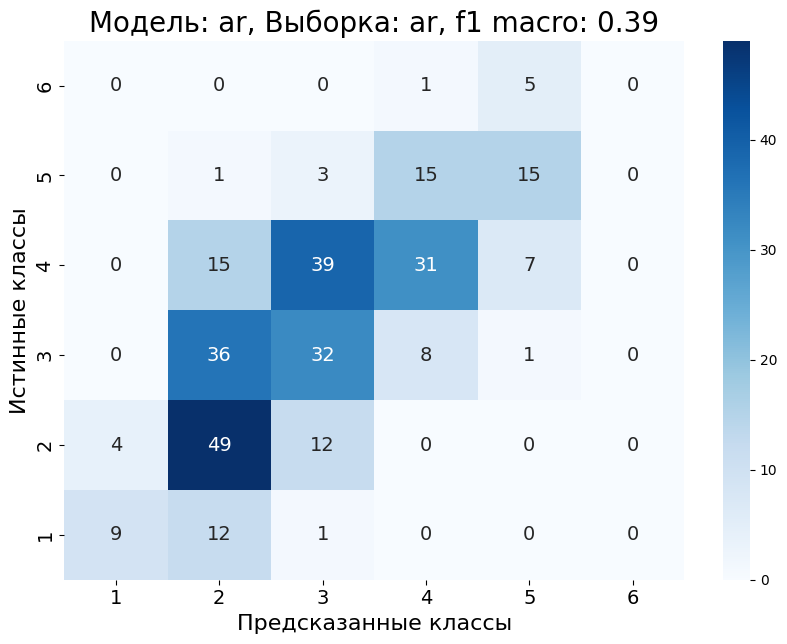

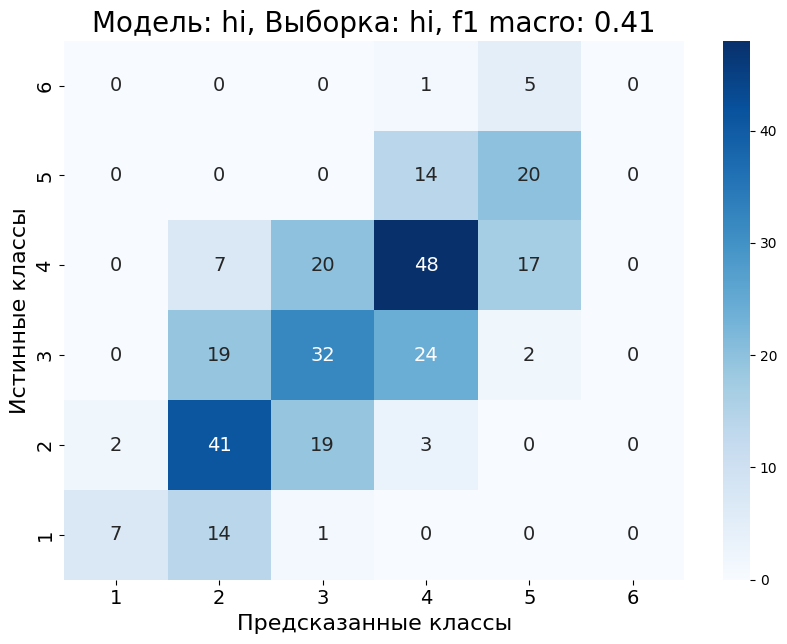

In [ ]:
for lang in ['en', 'ru', 'fr', 'ar', 'hi']:
    predictor = Pipeline(model, tokenizer, lang)
    preds = predictor.predict(load_data(lang).iloc[:, 0].values)
    plot_confusion_matrix(preds, labels, label_dict, category, language=lang, model_lang=lang)